# Baselines for TCR
The notebook `dataset-creation.ipyn` creates two dataset: the `α+β set`, and the `β set`. The `α+β set` contains `(CDR3α, CDR3β, peptide)` samples. The `β set` contains `(CDR3β, peptide)` samples.

In this notebook, we do experiments on ERGO II and NetTCR2.0 using them as baseline for our research. We train and test on the `β set`.

For testing, we operate 5 independent train/test splits of `β set` with different random seeds.

## Utility functions

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import trange
import random
import math
from scipy import interp
import statistics 

from tcrmodels.ergo2.model import ERGO2
from tcrmodels.nettcr2.model import NetTCR2

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import collections
from matplotlib import colors
from numpy.random import normal

Using TensorFlow backend.


In [2]:
metrics = [
    'AUROC',
    'Accuracy',
    #'Recall',
    'Precision',
    'F1 score',
    'AUPR'
]

def pr_auc(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return pr_auc

def get_scores(y_true, y_prob, y_pred):
    """
    Compute a df with all classification metrics and respective scores.
    """
    
    scores = [
        roc_auc_score(y_true, y_prob),
        accuracy_score(y_true, y_pred),
        #recall_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        pr_auc(y_true, y_prob)
    ]
    
    df = pd.DataFrame(data={'score': scores, 'metrics': metrics})
    return df

In [3]:
blosum50_20aa = {
    'A': np.array((5,-2,-1,-2,-1,-1,-1,0,-2,-1,-2,-1,-1,-3,-1,1,0,-3,-2,0)),
    'R': np.array((-2,7,-1,-2,-4,1,0,-3,0,-4,-3,3,-2,-3,-3,-1,-1,-3,-1,-3)),
    'N': np.array((-1,-1,7,2,-2,0,0,0,1,-3,-4,0,-2,-4,-2,1,0,-4,-2,-3)),
    'D': np.array((-2,-2,2,8,-4,0,2,-1,-1,-4,-4,-1,-4,-5,-1,0,-1,-5,-3,-4)),
    'C': np.array((-1,-4,-2,-4,13,-3,-3,-3,-3,-2,-2,-3,-2,-2,-4,-1,-1,-5,-3,-1)),
    'Q': np.array((-1,1,0,0,-3,7,2,-2,1,-3,-2,2,0,-4,-1,0,-1,-1,-1,-3)),
    'E': np.array((-1,0,0,2,-3,2,6,-3,0,-4,-3,1,-2,-3,-1,-1,-1,-3,-2,-3)),
    'G': np.array((0,-3,0,-1,-3,-2,-3,8,-2,-4,-4,-2,-3,-4,-2,0,-2,-3,-3,-4)),
    'H': np.array((-2,0,1,-1,-3,1,0,-2,10,-4,-3,0,-1,-1,-2,-1,-2,-3,2,-4)),
    'I': np.array((-1,-4,-3,-4,-2,-3,-4,-4,-4,5,2,-3,2,0,-3,-3,-1,-3,-1,4)),
    'L': np.array((-2,-3,-4,-4,-2,-2,-3,-4,-3,2,5,-3,3,1,-4,-3,-1,-2,-1,1)),
    'K': np.array((-1,3,0,-1,-3,2,1,-2,0,-3,-3,6,-2,-4,-1,0,-1,-3,-2,-3)),
    'M': np.array((-1,-2,-2,-4,-2,0,-2,-3,-1,2,3,-2,7,0,-3,-2,-1,-1,0,1)),
    'F': np.array((-3,-3,-4,-5,-2,-4,-3,-4,-1,0,1,-4,0,8,-4,-3,-2,1,4,-1)),
    'P': np.array((-1,-3,-2,-1,-4,-1,-1,-2,-2,-3,-4,-1,-3,-4,10,-1,-1,-4,-3,-3)),
    'S': np.array((1,-1,1,0,-1,0,-1,0,-1,-3,-3,0,-2,-3,-1,5,2,-4,-2,-2)),
    'T': np.array((0,-1,0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1,2,5,-3,-2,0)),
    'W': np.array((-3,-3,-4,-5,-5,-1,-3,-3,-3,-3,-2,-3,-1,1,-4,-4,-3,15,2,-3)),
    'Y': np.array((-2,-1,-2,-3,-3,-1,-2,-3,2,-1,-1,-2,0,4,-3,-2,-2,2,8,-1)),
    'V': np.array((0,-3,-3,-4,-1,-3,-3,-4,-4,4,1,-3,1,-1,-3,-2,0,-3,-1,5))
}

def enc_list_bl_max_len(aas, blosum, max_seq_len):
    '''
    blosum encoding of a list of amino acid sequences with padding 
    to a max length

    parameters:
        - aa_seqs : list with AA sequences
        - blosum : dictionary: key= AA, value= blosum encoding
        - max_seq_len: common length for padding
    returns:
        padded_aa_encoding : array of padded amino acids encoding
    '''
    encoding_len = len(blosum['A'])
    padded_aa_encoding = np.zeros((encoding_len * max_seq_len))
    
    # encode amino acids
    for i, aa in enumerate(aas):
        padded_aa_encoding[i*encoding_len:(i+1)*encoding_len] = blosum[aa]
        
    return padded_aa_encoding

In [4]:
# Abbasi et al. implementation of LUPI-SVM does not predict probabilities
# we should do Platt scaling to estimate probabilities of a SVM
# but since that would be a complex implementation, we use a sigmoid
from scipy.stats import logistic

def sigmoid(x):
    return logistic.cdf(x)

In [5]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"

# NetTCR2.0 - Peptide+CDR3β

In [ ]:
%%capture

df_dataset = pd.read_csv(DATA_BASE + "alpha-beta-splits/beta.csv")
test_files = ('(β-set', [])
results_nettcr2 = []

for i in tqdm(range(5)):
    df_train, df_test = train_test_split(df_dataset, test_size=0.2, random_state=i)
    test_files[1].append(df_test.reset_index())

    model = NetTCR2(
        architecture="b", 
        single_chain_column='tcrb',
        peptide_column='peptide',
        label_column='sign',
        max_pep_len=df_dataset.peptide.str.len().max(), 
        max_cdr3_len=df_dataset.tcrb.str.len().max()
    )
    model.train(df_train, epochs=1000);

    prediction_df = model.test(test_files[1][i])
    scores_df = get_scores(
        y_true=prediction_df['sign'].to_numpy(), 
        y_prob=prediction_df['prediction'].to_numpy(),
        y_pred=prediction_df['prediction'].to_numpy().round(),
    )
    scores_df['experiment'] = "train_β-set_test_"+test_files[0]
    results_nettcr2.append(scores_df)
    test_files[1][i]['prediction_'+str(i)] = prediction_df['prediction']
        
results_nettcr2_df = pd.concat(results_nettcr2)

# save results for further analysis
for i, test_file in enumerate(test_files[1]):
    test_file.to_csv(
        RESULTS_BASE + f"nettcr2.baseline.beta-only.rep-{i}.csv",
        index=False
    )

# ERGO II - Peptide+CDR3β

In [9]:
%%capture

# the ERGO II data presents some files with a given header, and some others with a different one
map_keys = {
    'tcra': 'TRA',
    'tcrb': 'TRB',
    'va': 'TRAV',
    'ja': 'TRAJ',
    'vb': 'TRBV',
    'jb': 'TRBJ',
    't_cell_type': 'T-Cell-Type',
    'peptide': 'Peptide',
    'mhc': 'MHC',
    'protein': 'protein',
    'sign': 'sign'
}

df_dataset = pd.read_csv(DATA_BASE + "alpha-beta-splits/beta.csv")
results_ergo2 = []
test_files = ('(β-set', [])

for i in tqdm(range(5)):
    df_train, df_test = train_test_split(df_dataset, test_size=0.2, random_state=i)
    
    # the ERGO II implementation expected the following columns to be preset in the dataframe
    # even if they are not used
    df_test['va'] = pd.NA
    df_train['va'] = pd.NA
    df_test['vb'] = pd.NA
    df_train['vb'] = pd.NA
    df_test['ja'] = pd.NA
    df_train['ja'] = pd.NA
    df_test['jb'] = pd.NA
    df_train['jb'] = pd.NA
    df_test['mhc'] = pd.NA
    df_train['mhc'] = pd.NA
    df_test['t_cell_type'] = pd.NA
    df_train['t_cell_type'] = pd.NA
    df_test['protein'] = pd.NA
    df_train['protein'] = pd.NA

    # using "UNK" for identifier of missing CDR3α for test set
    df_test['tcra'] = "UNK"
    df_train['tcra'] = "UNK"

    df_test = df_test.rename(columns={c: map_keys[c] for c in df_test.columns})
    
    test_files[1].append(df_test.reset_index())

    model = ERGO2(
        gpu=[0],
        use_alpha=False,
        random_seed=i,
        train_val_ratio=.2,
    )
    model.train(df_train);

    prediction_df = model.test(test_files[1][i])
    scores_df = get_scores(
        y_true=prediction_df['sign'].to_numpy(), 
        y_prob=prediction_df['prediction'].to_numpy(),
        y_pred=prediction_df['prediction'].to_numpy().round(),
    )
    scores_df['experiment'] = "train_β-set_test_"+test_files[0]
    results_ergo2.append(scores_df)
    test_files[1][i]['prediction_'+str(i)] = prediction_df['prediction']
        
results_ergo2_df = pd.concat(results_ergo2)

# save results for further analysis
for i, test_file in enumerate(test_files[1]):
    test_file.to_csv(
        RESULTS_BASE + f"ergo2.baseline.beta-only.rep-{i}.csv",
        index=False
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcrb_encoder  | LSTM_Encoder | 3 M   
1 | pep_encoder   | LSTM_Encoder | 3 M   
2 | hidden_layer1 | Linear       | 31 K  
3 | relu          | LeakyReLU    | 0     
4 | output_layer1 | Linear       | 32    
5 | dropout       | Dropout      | 0     
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | tcrb_encoder  | LSTM_Encoder | 3 M   
1 | pep_encoder   | LSTM_Encoder | 3 M   
2 | hidden_layer1 | Linear       | 31 K  
3 | relu          | LeakyReLU    | 0     
4 | output_layer1 | Linear       | 32    
5 | dropout       | Dropout      | 0     
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name        

# Figures

In [6]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"

predictions_files = [
    #('RF-HPO | peptide+β', [pd.read_csv(RESULTS_BASE + f"rf-hpo.baseline.alpha+beta-only.rep-{i}.csv") for i in range(5)]),
    ('NetTCR2.0 | peptide+β', [pd.read_csv(RESULTS_BASE + f"nettcr2.baseline.beta-only.rep-{i}.csv") for i in range(5)]),
    ('ERGO II | peptide+β', [pd.read_csv(RESULTS_BASE + f"ergo2.baseline.beta-only.rep-{i}.csv") for i in range(5)]),
    ('AVIB | peptide+β', [pd.read_csv(RESULTS_BASE + f"mvib.bimodal.aoe.beta-only.rep-{i}.csv") for i in range(5)]),
    #('PVIB | α-privileged', [pd.read_csv(RESULTS_BASE + f"pvib.results.aoe.alpha+beta-only.rep-{i}.csv") for i in range(5)]),
]

100%|██████████| 5/5 [00:00<00:00,  8.48it/s]


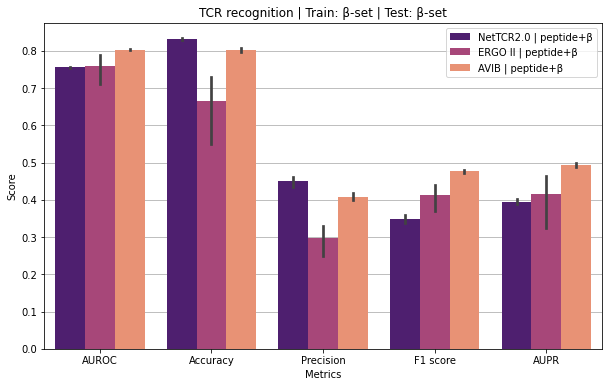

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)


results = []

for i in tqdm(range(5)):
    for predictions_file in predictions_files:
        prediction_df = predictions_file[1][i]
        if f'prediction_{i}' in prediction_df.columns:
            if "LUPI-SVM" in predictions_file[0]:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=sigmoid(prediction_df[f'prediction_{i}'].to_numpy()),
                    y_pred=np.sign(prediction_df[f'prediction_{i}'].to_numpy().round()).clip(min=0),
                )
            else:
                scores_df = get_scores(
                    y_true=prediction_df['sign'].to_numpy(), 
                    y_prob=prediction_df[f'prediction_{i}'].to_numpy(),
                    y_pred=prediction_df[f'prediction_{i}'].to_numpy().round(),
                )
            scores_df['Model'] = predictions_file[0]
            results.append(scores_df)
        
results_df = pd.concat(results).rename(columns={'metrics': 'Metrics', 'score': 'Score'})

plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(
    x="Metrics",
    y="Score", 
    hue="Model", 
    data=results_df,
    palette=sns.color_palette("magma", len(predictions_files))
)
ax.set_title('TCR recognition | Train: β-set | Test: β-set')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
ax.grid(axis='y')

plt.savefig(FIGURES_BASE + "baseline.beta-only.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_BASE + "baseline.beta-only.png", format='png', dpi=300, bbox_inches='tight')

In [8]:
results_df.groupby(['Metrics', 'Model']).mean()

Score
Metrics   Model                          
AUPR      AVIB | peptide+β       0.493731
          ERGO II | peptide+β    0.415308
          NetTCR2.0 | peptide+β  0.395091
AUROC     AVIB | peptide+β       0.803558
          ERGO II | peptide+β    0.760602
          NetTCR2.0 | peptide+β  0.755789
Accuracy  AVIB | peptide+β       0.801638
          ERGO II | peptide+β    0.664831
          NetTCR2.0 | peptide+β  0.832334
F1 score  AVIB | peptide+β       0.476913
          ERGO II | peptide+β    0.412495
          NetTCR2.0 | peptide+β  0.348883
Precision AVIB | peptide+β       0.408368
          ERGO II | peptide+β    0.296352
          NetTCR2.0 | peptide+β  0.450016

In [9]:
ste = results_df.groupby(['Metrics', 'Model']).std()
ste['Score'] = ste['Score'].apply(lambda x: x / 5)
ste

Score
Metrics   Model                          
AUPR      AVIB | peptide+β       0.001424
          ERGO II | peptide+β    0.019986
          NetTCR2.0 | peptide+β  0.001759
AUROC     AVIB | peptide+β       0.000290
          ERGO II | peptide+β    0.011014
          NetTCR2.0 | peptide+β  0.000625
Accuracy  AVIB | peptide+β       0.001563
          ERGO II | peptide+β    0.025287
          NetTCR2.0 | peptide+β  0.000504
F1 score  AVIB | peptide+β       0.000930
          ERGO II | peptide+β    0.009820
          NetTCR2.0 | peptide+β  0.002694
Precision AVIB | peptide+β       0.002563
          ERGO II | peptide+β    0.011069
          NetTCR2.0 | peptide+β  0.003514

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('axes', axisbelow=True)

plt.style.use('seaborn-white')
sns.set_palette('magma', len(predictions_files))


def make_roc_curve_plot(ax, true_values_list, predicted_values_list, cutoff, model_label):
    """Calculate ROC and AUC from lists of true and predicted values and draw."""

    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    auc = []
    for true_values, predicted_values in zip(true_values_list, predicted_values_list):
        fpr, tpr, thresholds = roc_curve(true_values, predicted_values)
        auc.append(roc_auc_score(true_values, predicted_values))
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)

    ax.plot(base_fpr, mean_tprs, label=model_label+str(f" | AUROC: {statistics.mean(auc):.3f}"))
    
    ax.set_title("ROC Curve | Train: β-set | Test: β-set")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.legend()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    
#     for fp, tp, threshold in zip(fpr, tpr, thresholds):
#         if threshold < cutoff:
#             ax.plot(fp, tp, marker='o', markersize=10, color='grey', alpha=0.75)
#             break


def make_uninformative_roc(ax):
    ax.plot([0, 1], [0, 1], c='grey', linestyle='dashed', alpha=0.5, label="Uninformative test")
    ax.legend()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(facecolor="white")


fig, ax = plt.subplots()

for predictions_file in predictions_files:
    true_values_list, predicted_values_list = [], []
    for i in range(5):
        prediction_df = predictions_file[1][i]
        true_values_list.append(prediction_df['sign'].to_numpy())
        if "LUPI-SVM" in predictions_file[0]:
            predicted_values_list.append(sigmoid(prediction_df[f'prediction_{i}'].to_numpy()))
        else:
            predicted_values_list.append(prediction_df[f'prediction_{i}'].to_numpy())

    make_roc_curve_plot(
        ax, 
        true_values_list, 
        predicted_values_list, 
        0.9,
        predictions_file[0]
    )
make_uninformative_roc(ax)
ax.tick_params(axis='x', pad=15)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.savefig(FIGURES_BASE + "roc.beta-only.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_BASE + "roc.beta-only.png", format='png', dpi=300, bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('axes', axisbelow=True)

def make_prc_curve_plot(ax, true_values, predicted_values, model_label):
    """Calculate PRC and AUC from lists of true and predicted values and draw."""
    
    reversed_mean_precision = 0.0
    base_recall = np.linspace(1, 0, 100)
    auc = []
    
    for true_values, predicted_values in zip(true_values_list, predicted_values_list):
        precision, recall, thresholds = precision_recall_curve(true_values, predicted_values)
        auc.append(pr_auc(true_values, predicted_values))
        reversed_recall = np.fliplr([recall])[0]
        reversed_precision = np.fliplr([precision])[0]
        reversed_mean_precision += interp(base_recall, reversed_recall, reversed_precision)
    
    reversed_mean_precision /= 5
    
    ax.plot(base_recall, reversed_mean_precision, label=model_label+str(f" | AUPR: {statistics.mean(auc):.3f}"))
    
    ax.set_title("Precision-Recall Curve | Train: β-set | Test: β-set")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.legend()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])


fig, ax = plt.subplots()

for predictions_file in predictions_files:
    true_values_list, predicted_values_list = [], []
    for i in range(5):
        prediction_df = predictions_file[1][i]
        true_values_list.append(prediction_df['sign'].to_numpy())
        if "LUPI-SVM" in predictions_file[0]:  # LUPI-SSVM
            predicted_values_list.append(sigmoid(prediction_df[f'prediction_{i}'].to_numpy()))
        else:
            predicted_values_list.append(prediction_df[f'prediction_{i}'].to_numpy())

    make_prc_curve_plot(
        ax, 
        true_values_list, 
        predicted_values_list, 
        predictions_file[0]
    )

ax.tick_params(axis='x', pad=15)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig(FIGURES_BASE + "prc.beta-only.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_BASE + "prc.beta-only.png", format='png', dpi=300, bbox_inches='tight')

# MVIB - Experts comparison

In [21]:
predictions_files = [
    ('AVIB (AoE) | peptide+β', [pd.read_csv(RESULTS_BASE + f"mvib.bimodal.aoe.beta-only.rep-{i}.csv") for i in range(5)]),
    ('MVIB (PoE) | peptide+β', [pd.read_csv(RESULTS_BASE + f"mvib.bimodal.poe.beta-only.rep-{i}.csv") for i in range(5)]),
]


100%|██████████| 5/5 [00:00<00:00,  7.59it/s]


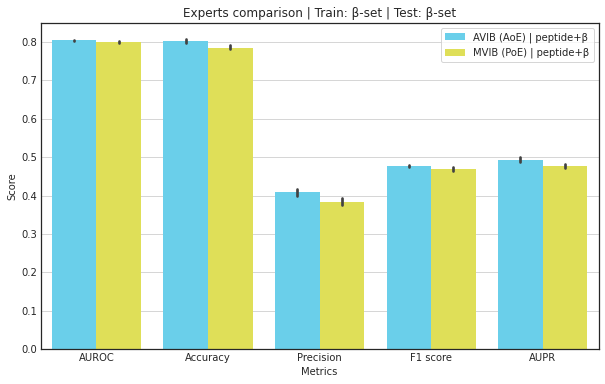

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)


results = []
colors = ["#55DCFF", "#F5F542", ]

for i in tqdm(range(5)):
    for predictions_file in predictions_files:
        prediction_df = predictions_file[1][i]
        if f'prediction_{i}' in prediction_df.columns:
            scores_df = get_scores(
                y_true=prediction_df['sign'].to_numpy(), 
                y_prob=prediction_df[f'prediction_{i}'].to_numpy(),
                y_pred=prediction_df[f'prediction_{i}'].to_numpy().round(),
            )
            scores_df['Model'] = predictions_file[0]
            results.append(scores_df)
        
results_df = pd.concat(results).rename(columns={'metrics': 'Metrics', 'score': 'Score'})

plt.rcParams['figure.figsize'] = [10, 6]
ax = sns.barplot(
    x="Metrics",
    y="Score", 
    hue="Model", 
    data=results_df,
    palette=sns.color_palette(colors, 4)
)
ax.set_title('Experts comparison | Train: β-set | Test: β-set')
ax.legend(loc='best')
ax.grid(axis='y')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig(FIGURES_BASE + "experts-comparison.beta-only.svg", format='svg', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_BASE + "experts-comparison.beta-only.png", format='png', dpi=300, bbox_inches='tight')

In [24]:
results_df.groupby(['Metrics', 'Model']).mean()

Score
Metrics   Model                           
AUPR      AVIB (AoE) | peptide+β  0.493731
          MVIB (PoE) | peptide+β  0.476889
AUROC     AVIB (AoE) | peptide+β  0.803558
          MVIB (PoE) | peptide+β  0.799978
Accuracy  AVIB (AoE) | peptide+β  0.801638
          MVIB (PoE) | peptide+β  0.785062
F1 score  AVIB (AoE) | peptide+β  0.476913
          MVIB (PoE) | peptide+β  0.467851
Precision AVIB (AoE) | peptide+β  0.408368
          MVIB (PoE) | peptide+β  0.383762

In [25]:
results_df.groupby(['Metrics', 'Model']).std()

Score
Metrics   Model                           
AUPR      AVIB (AoE) | peptide+β  0.007120
          MVIB (PoE) | peptide+β  0.008027
AUROC     AVIB (AoE) | peptide+β  0.001449
          MVIB (PoE) | peptide+β  0.003818
Accuracy  AVIB (AoE) | peptide+β  0.007815
          MVIB (PoE) | peptide+β  0.006497
F1 score  AVIB (AoE) | peptide+β  0.004649
          MVIB (PoE) | peptide+β  0.006471
Precision AVIB (AoE) | peptide+β  0.012814
          MVIB (PoE) | peptide+β  0.011508